<a href="https://colab.research.google.com/github/hkhong72/big_data/blob/main/221101_8_Chap19(%EA%B0%95%EC%82%AC%EB%8B%98%EB%B2%84%EC%A0%84).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras import models, layers
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [ ]:
generator = models.Sequential()
generator.add(layers.Dense(128*7*7, input_dim=100, activation=layers.LeakyReLU(0.2)))
generator.add(layers.BatchNormalization())
generator.add(layers.Reshape((7, 7, 128)))
generator.add(layers.UpSampling2D())
generator.add(layers.Conv2D(64, kernel_size=5, padding='same'))
generator.add(layers.BatchNormalization())
generator.add(layers.Activation(layers.LeakyReLU(0.2)))
generator.add(layers.UpSampling2D())
generator.add(layers.Conv2D(1, kernel_size=5, padding='same', activation='tanh'))
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 batch_normalization (BatchN  (None, 6272)             25088     
 ormalization)                                                   
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        204864    
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       2

In [ ]:
discriminator = models.Sequential()
discriminator.add(layers.Conv2D(64, kernel_size=5, input_shape=(28, 28, 1),
                               strides=2, padding='same'))
discriminator.add(layers.Activation(layers.LeakyReLU(0.2)))
discriminator.add(layers.Dropout(0.3))
discriminator.add(layers.Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(layers.Activation(layers.LeakyReLU(0.2)))
discriminator.add(layers.Dropout(0.3))
discriminator.add(layers.Flatten())
discriminator.add(layers.Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

In [ ]:
ginput = layers.Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = models.Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         865281    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [ ]:
def gan_train(epoch, batch_size, saving_interval):
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype(float)
    X_train = (X_train - 127.5) / 127.5
    
    true = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for i in range(epoch):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        d_loss_real = discriminator.train_on_batch(imgs, true)
        
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        g_loss = gan.train_on_batch(noise, true)
        
        print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)
        
        if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("./gan_images/gan_mnist_%d.png" % i)

epoch:0  d_loss:0.7185  g_loss:0.3994
epoch:1  d_loss:0.5057  g_loss:0.1419
epoch:2  d_loss:0.5000  g_loss:0.0531
epoch:3  d_loss:0.5289  g_loss:0.0635
epoch:4  d_loss:0.5217  g_loss:0.1478
epoch:5  d_loss:0.4861  g_loss:0.3348
epoch:6  d_loss:0.4539  g_loss:0.6187
epoch:7  d_loss:0.4213  g_loss:0.9414
epoch:8  d_loss:0.4137  g_loss:1.1843
epoch:9  d_loss:0.3804  g_loss:1.3624
epoch:10  d_loss:0.4196  g_loss:1.2350
epoch:11  d_loss:0.6812  g_loss:1.0923
epoch:12  d_loss:0.8156  g_loss:0.8612
epoch:13  d_loss:1.0356  g_loss:0.5386
epoch:14  d_loss:0.7100  g_loss:0.5503
epoch:15  d_loss:0.6672  g_loss:0.6062
epoch:16  d_loss:0.5626  g_loss:0.7527
epoch:17  d_loss:0.5791  g_loss:0.6701
epoch:18  d_loss:0.5124  g_loss:0.6321
epoch:19  d_loss:0.4881  g_loss:0.6494
epoch:20  d_loss:0.4515  g_loss:0.6367
epoch:21  d_loss:0.4231  g_loss:0.6910
epoch:22  d_loss:0.4177  g_loss:0.7890
epoch:23  d_loss:0.4336  g_loss:0.8090
epoch:24  d_loss:0.3660  g_loss:0.8557
epoch:25  d_loss:0.4557  g_loss:0.8

epoch:209  d_loss:0.4511  g_loss:2.0633
epoch:210  d_loss:0.3241  g_loss:2.7986
epoch:211  d_loss:0.5378  g_loss:2.9529
epoch:212  d_loss:0.3715  g_loss:2.8094
epoch:213  d_loss:0.4847  g_loss:2.3068
epoch:214  d_loss:0.5213  g_loss:2.0528
epoch:215  d_loss:0.6166  g_loss:2.0729
epoch:216  d_loss:0.4454  g_loss:2.3711
epoch:217  d_loss:0.5655  g_loss:2.2358
epoch:218  d_loss:0.6901  g_loss:2.0744
epoch:219  d_loss:0.5393  g_loss:2.2302
epoch:220  d_loss:0.4615  g_loss:2.5640
epoch:221  d_loss:0.6534  g_loss:1.8457
epoch:222  d_loss:0.5874  g_loss:1.6339
epoch:223  d_loss:0.5567  g_loss:1.5167
epoch:224  d_loss:0.3908  g_loss:1.6155
epoch:225  d_loss:0.4433  g_loss:1.7584
epoch:226  d_loss:0.4061  g_loss:1.9449
epoch:227  d_loss:0.5421  g_loss:2.1010
epoch:228  d_loss:0.5678  g_loss:1.8788
epoch:229  d_loss:0.3556  g_loss:1.8669
epoch:230  d_loss:0.3484  g_loss:1.8614
epoch:231  d_loss:0.2816  g_loss:2.5050
epoch:232  d_loss:0.3405  g_loss:2.1484
epoch:233  d_loss:0.2730  g_loss:2.4283


epoch:415  d_loss:0.2954  g_loss:2.7416
epoch:416  d_loss:0.2530  g_loss:2.5657
epoch:417  d_loss:0.2792  g_loss:2.5478
epoch:418  d_loss:0.2036  g_loss:2.4564
epoch:419  d_loss:0.3257  g_loss:2.7675
epoch:420  d_loss:0.2866  g_loss:2.6313
epoch:421  d_loss:0.2656  g_loss:2.7051
epoch:422  d_loss:0.1499  g_loss:2.8317
epoch:423  d_loss:0.3055  g_loss:2.3352
epoch:424  d_loss:0.2215  g_loss:2.6403
epoch:425  d_loss:0.2244  g_loss:2.8576
epoch:426  d_loss:0.2093  g_loss:2.8567
epoch:427  d_loss:0.1535  g_loss:3.0992
epoch:428  d_loss:0.1930  g_loss:2.7114
epoch:429  d_loss:0.2497  g_loss:2.5170
epoch:430  d_loss:0.1976  g_loss:2.4464
epoch:431  d_loss:0.1830  g_loss:2.6932
epoch:432  d_loss:0.1253  g_loss:2.5347
epoch:433  d_loss:0.1444  g_loss:3.1445
epoch:434  d_loss:0.1768  g_loss:2.8061
epoch:435  d_loss:0.1825  g_loss:2.8514
epoch:436  d_loss:0.2111  g_loss:2.6154
epoch:437  d_loss:0.2399  g_loss:2.6172
epoch:438  d_loss:0.1328  g_loss:2.7971
epoch:439  d_loss:0.1621  g_loss:3.2504


epoch:621  d_loss:0.3938  g_loss:6.1604
epoch:622  d_loss:0.5115  g_loss:4.6751
epoch:623  d_loss:0.5436  g_loss:4.7688
epoch:624  d_loss:0.1815  g_loss:4.7151
epoch:625  d_loss:0.6451  g_loss:3.6761
epoch:626  d_loss:0.4385  g_loss:3.4059
epoch:627  d_loss:0.5182  g_loss:3.2270
epoch:628  d_loss:0.3484  g_loss:3.3313
epoch:629  d_loss:0.2657  g_loss:2.9627
epoch:630  d_loss:0.4168  g_loss:3.3195
epoch:631  d_loss:0.4904  g_loss:2.7554
epoch:632  d_loss:0.5647  g_loss:1.8556
epoch:633  d_loss:0.4088  g_loss:1.8984
epoch:634  d_loss:0.5099  g_loss:1.5375
epoch:635  d_loss:0.5440  g_loss:1.4679
epoch:636  d_loss:0.5899  g_loss:1.4505
epoch:637  d_loss:0.5791  g_loss:1.2646
epoch:638  d_loss:0.6167  g_loss:1.2973
epoch:639  d_loss:0.5797  g_loss:1.2288
epoch:640  d_loss:0.5256  g_loss:1.6602
epoch:641  d_loss:0.4634  g_loss:1.6812
epoch:642  d_loss:0.5015  g_loss:1.7475
epoch:643  d_loss:0.3978  g_loss:1.5672
epoch:644  d_loss:0.3726  g_loss:1.3830
epoch:645  d_loss:0.3065  g_loss:1.6393


epoch:827  d_loss:0.4276  g_loss:2.6942
epoch:828  d_loss:0.2608  g_loss:2.4184
epoch:829  d_loss:0.3948  g_loss:2.4053
epoch:830  d_loss:0.2766  g_loss:2.2007
epoch:831  d_loss:0.3751  g_loss:2.2954
epoch:832  d_loss:0.2514  g_loss:1.9062
epoch:833  d_loss:0.3064  g_loss:1.7154
epoch:834  d_loss:0.3024  g_loss:1.9565
epoch:835  d_loss:0.3390  g_loss:1.7661
epoch:836  d_loss:0.3730  g_loss:2.2890
epoch:837  d_loss:0.3778  g_loss:1.9268
epoch:838  d_loss:0.3790  g_loss:2.3000
epoch:839  d_loss:0.4097  g_loss:2.0057
epoch:840  d_loss:0.2999  g_loss:2.3632
epoch:841  d_loss:0.2787  g_loss:2.3675
epoch:842  d_loss:0.2310  g_loss:2.5236
epoch:843  d_loss:0.1521  g_loss:2.9553
epoch:844  d_loss:0.2884  g_loss:2.8480
epoch:845  d_loss:0.2281  g_loss:2.8787
epoch:846  d_loss:0.2975  g_loss:2.5312
epoch:847  d_loss:0.3489  g_loss:2.5461
epoch:848  d_loss:0.4122  g_loss:2.2116
epoch:849  d_loss:0.4755  g_loss:2.0063
epoch:850  d_loss:0.6978  g_loss:1.9819
epoch:851  d_loss:0.9028  g_loss:1.5200


epoch:1033  d_loss:0.3589  g_loss:2.2118
epoch:1034  d_loss:0.3911  g_loss:2.4761
epoch:1035  d_loss:0.4217  g_loss:2.0805
epoch:1036  d_loss:0.4986  g_loss:1.6344
epoch:1037  d_loss:0.3482  g_loss:1.8924
epoch:1038  d_loss:0.4820  g_loss:1.5461
epoch:1039  d_loss:0.4999  g_loss:1.7087
epoch:1040  d_loss:0.3786  g_loss:2.4389
epoch:1041  d_loss:0.5417  g_loss:2.1759
epoch:1042  d_loss:0.6411  g_loss:1.8220
epoch:1043  d_loss:0.5604  g_loss:1.7572
epoch:1044  d_loss:0.5524  g_loss:1.8916
epoch:1045  d_loss:0.5978  g_loss:1.5901
epoch:1046  d_loss:0.4480  g_loss:1.5538
epoch:1047  d_loss:0.5449  g_loss:1.7020
epoch:1048  d_loss:0.5375  g_loss:1.8892
epoch:1049  d_loss:0.5179  g_loss:1.8333
epoch:1050  d_loss:0.6836  g_loss:1.7155
epoch:1051  d_loss:0.7414  g_loss:1.4725
epoch:1052  d_loss:0.6260  g_loss:1.3394
epoch:1053  d_loss:0.5296  g_loss:1.4515
epoch:1054  d_loss:0.5459  g_loss:1.6256
epoch:1055  d_loss:0.5034  g_loss:1.9707
epoch:1056  d_loss:0.5871  g_loss:1.6212
epoch:1057  d_lo

epoch:1233  d_loss:0.3616  g_loss:2.1024
epoch:1234  d_loss:0.2576  g_loss:2.3048
epoch:1235  d_loss:0.3971  g_loss:2.3817
epoch:1236  d_loss:0.2503  g_loss:2.2105
epoch:1237  d_loss:0.2869  g_loss:2.5663
epoch:1238  d_loss:0.3750  g_loss:1.8833
epoch:1239  d_loss:0.5163  g_loss:1.6924
epoch:1240  d_loss:0.3468  g_loss:2.0613
epoch:1241  d_loss:0.3127  g_loss:2.0242
epoch:1242  d_loss:0.4272  g_loss:1.9029
epoch:1243  d_loss:0.4885  g_loss:1.6481
epoch:1244  d_loss:0.5289  g_loss:1.8313
epoch:1245  d_loss:0.4900  g_loss:1.9503
epoch:1246  d_loss:0.4408  g_loss:2.1377
epoch:1247  d_loss:0.4937  g_loss:2.3689
epoch:1248  d_loss:0.3912  g_loss:1.9403
epoch:1249  d_loss:0.3113  g_loss:2.0631
epoch:1250  d_loss:0.3701  g_loss:2.1522
epoch:1251  d_loss:0.4529  g_loss:2.1676
epoch:1252  d_loss:0.2874  g_loss:2.1938
epoch:1253  d_loss:0.4575  g_loss:2.1345
epoch:1254  d_loss:0.3903  g_loss:1.5643
epoch:1255  d_loss:0.3390  g_loss:2.0012
epoch:1256  d_loss:0.5198  g_loss:1.5088
epoch:1257  d_lo

epoch:1433  d_loss:0.5831  g_loss:1.5116
epoch:1434  d_loss:0.5496  g_loss:1.5472
epoch:1435  d_loss:0.5732  g_loss:1.3915
epoch:1436  d_loss:0.6356  g_loss:1.4188
epoch:1437  d_loss:0.4502  g_loss:1.9006
epoch:1438  d_loss:0.3272  g_loss:2.2879
epoch:1439  d_loss:0.4370  g_loss:2.2838
epoch:1440  d_loss:0.4556  g_loss:2.5105
epoch:1441  d_loss:0.4175  g_loss:1.9643
epoch:1442  d_loss:0.4711  g_loss:1.5440
epoch:1443  d_loss:0.5529  g_loss:1.8820
epoch:1444  d_loss:0.4469  g_loss:1.9648
epoch:1445  d_loss:0.3499  g_loss:2.3851
epoch:1446  d_loss:0.3351  g_loss:2.5857
epoch:1447  d_loss:0.4230  g_loss:1.9486
epoch:1448  d_loss:0.3430  g_loss:2.0180
epoch:1449  d_loss:0.3878  g_loss:1.9499
epoch:1450  d_loss:0.3475  g_loss:1.9928
epoch:1451  d_loss:0.4199  g_loss:1.8660
epoch:1452  d_loss:0.3567  g_loss:2.0515
epoch:1453  d_loss:0.2982  g_loss:2.0712
epoch:1454  d_loss:0.2855  g_loss:2.5405
epoch:1455  d_loss:0.2381  g_loss:2.5841
epoch:1456  d_loss:0.2520  g_loss:2.2101
epoch:1457  d_lo

epoch:1633  d_loss:0.3795  g_loss:1.9172
epoch:1634  d_loss:0.4513  g_loss:2.1043
epoch:1635  d_loss:0.3341  g_loss:2.0816
epoch:1636  d_loss:0.4459  g_loss:1.8189
epoch:1637  d_loss:0.5125  g_loss:1.5889
epoch:1638  d_loss:0.4265  g_loss:1.6970
epoch:1639  d_loss:0.5598  g_loss:1.3737
epoch:1640  d_loss:0.4495  g_loss:1.6159
epoch:1641  d_loss:0.5011  g_loss:1.6581
epoch:1642  d_loss:0.5497  g_loss:1.9072
epoch:1643  d_loss:0.4382  g_loss:1.5570
epoch:1644  d_loss:0.3165  g_loss:1.8922
epoch:1645  d_loss:0.6722  g_loss:1.5913
epoch:1646  d_loss:0.5242  g_loss:1.4998
epoch:1647  d_loss:0.5787  g_loss:1.3619
epoch:1648  d_loss:0.4868  g_loss:1.4582
epoch:1649  d_loss:0.5187  g_loss:1.8750
epoch:1650  d_loss:0.4098  g_loss:1.8380
epoch:1651  d_loss:0.4211  g_loss:2.0340
epoch:1652  d_loss:0.4817  g_loss:1.6621
epoch:1653  d_loss:0.4411  g_loss:1.4786
epoch:1654  d_loss:0.4750  g_loss:1.3438
epoch:1655  d_loss:0.3524  g_loss:1.6614
epoch:1656  d_loss:0.2740  g_loss:2.2002
epoch:1657  d_lo

epoch:1833  d_loss:0.5539  g_loss:1.2634
epoch:1834  d_loss:0.5268  g_loss:1.4053
epoch:1835  d_loss:0.6199  g_loss:1.5101
epoch:1836  d_loss:0.5790  g_loss:1.6556
epoch:1837  d_loss:0.5204  g_loss:1.5633
epoch:1838  d_loss:0.4382  g_loss:1.5563
epoch:1839  d_loss:0.4559  g_loss:1.3864
epoch:1840  d_loss:0.4761  g_loss:1.6230
epoch:1841  d_loss:0.4863  g_loss:1.6055
epoch:1842  d_loss:0.3891  g_loss:2.1148
epoch:1843  d_loss:0.4306  g_loss:2.0069
epoch:1844  d_loss:0.3259  g_loss:2.1986
epoch:1845  d_loss:0.3969  g_loss:1.7187
epoch:1846  d_loss:0.4636  g_loss:1.7116
epoch:1847  d_loss:0.3794  g_loss:1.7759
epoch:1848  d_loss:0.3152  g_loss:1.9236
epoch:1849  d_loss:0.4337  g_loss:1.9746
epoch:1850  d_loss:0.3347  g_loss:1.6952
epoch:1851  d_loss:0.3921  g_loss:2.0085
epoch:1852  d_loss:0.3535  g_loss:2.0373
epoch:1853  d_loss:0.4393  g_loss:2.3164
epoch:1854  d_loss:0.3388  g_loss:2.1526
epoch:1855  d_loss:0.2920  g_loss:2.1753
epoch:1856  d_loss:0.3300  g_loss:2.3136
epoch:1857  d_lo

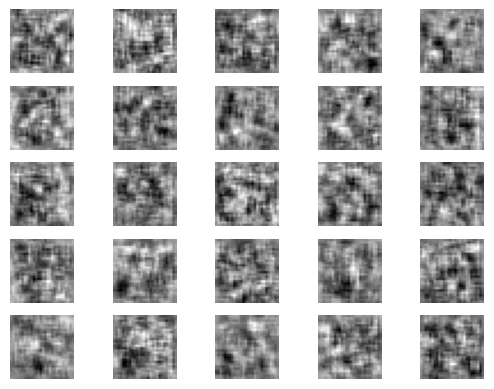

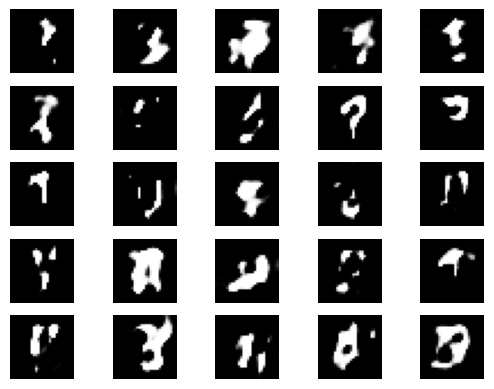

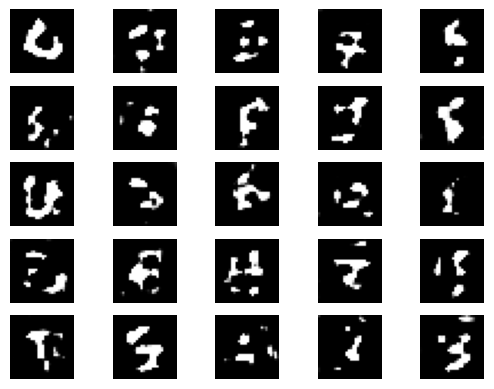

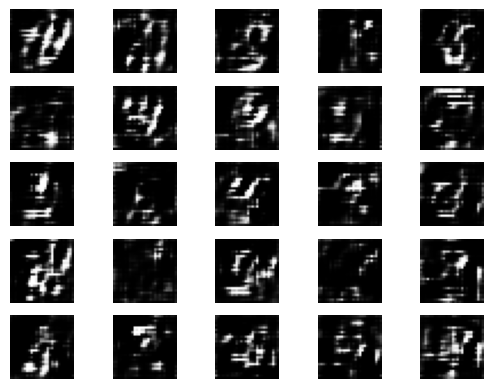

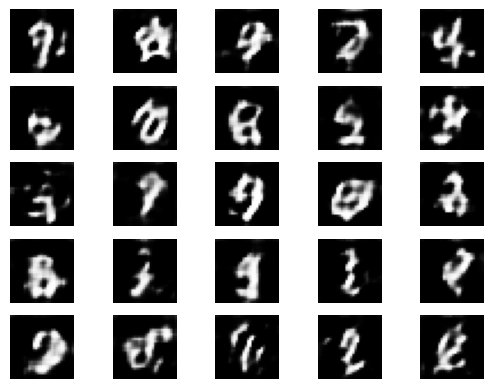

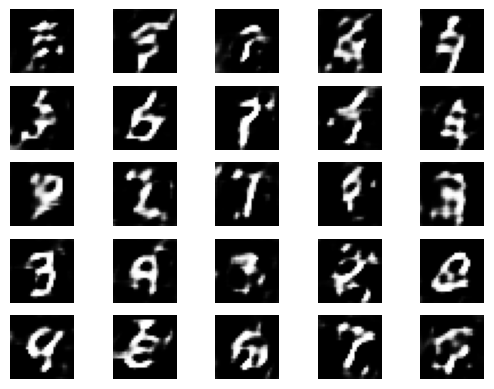

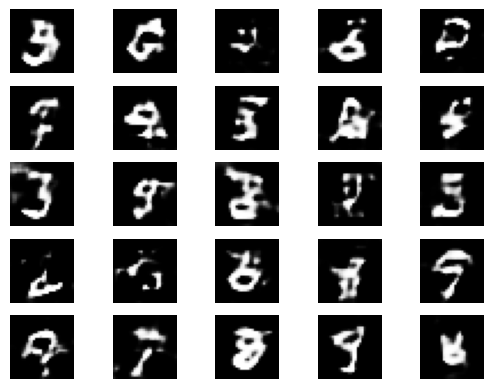

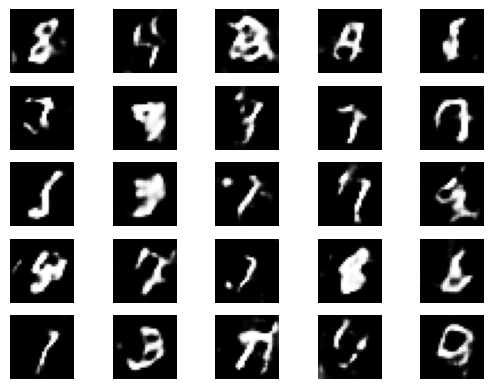

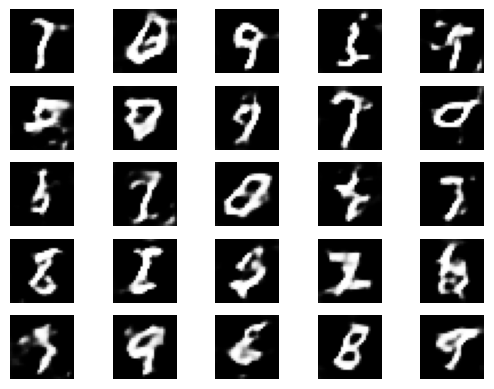

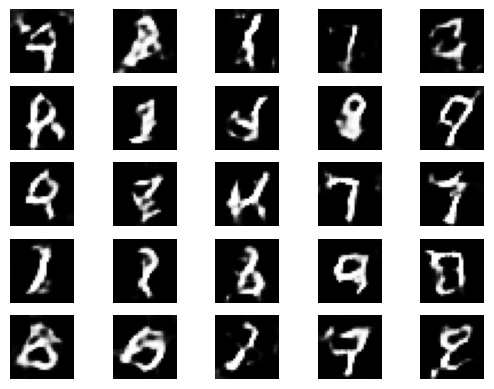

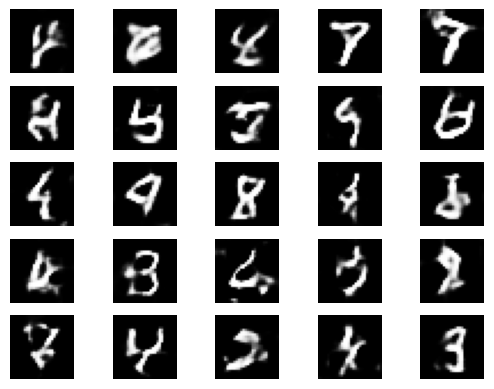

In [ ]:
gan_train(2001, 32, 200)